In [48]:
from utils.binaries import *
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from utils import CONSTANTS
import os

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, mode, t=None, version=None):
     
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC = CONSTANTS.UUB_WCD_PEAK if mode == 'peak' else CONSTANTS.UUB_WCD_CHARGE
        case 3:
            ADC = CONSTANTS.UUB_SSD_PEAK if mode == 'peak' else CONSTANTS.UUB_SSD_CHARGE
    
    if mode == 'peak' or p == 3:
        order = 50
        _peaks = argrelextrema(counts[:100], np.greater, order=order)[0]
        while len(_peaks) == 1:
            order -= 1
            _peaks = argrelextrema(counts[:100], np.greater, order=order)[0]
        _peak = _peaks[-1]
        _range = 7 if p != 3 else 20
        start, stop = _peak - _range, _peak + _range
    elif mode == 'charge':
        order = 1
        _peaks = argrelextrema(counts[:200], np.greater, order=order)[0]
        while len(_peaks) != 1:
            order += 1
            _peaks = argrelextrema(counts[:200], np.greater, order=order)[0]
        _peak = _peaks[-1]
        start, stop = np.max([0, _peak - 40]), _peak + 40


    try:
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, ADC[_peak], counts[_peak]])

        file_loc = f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/{t}-{mode}.png"

        if not os.path.isfile(file_loc):
            os.makedirs(f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/", exist_ok=True)
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.axvline(ADC[start], c='k', lw=0.3, ls='--')
            plt.axvline(ADC[stop], c='k', lw=0.3, ls='--')
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{t}-{mode}.png')
            plt.close(fig)

        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError
        if mip.n > 300 and mode=='peak': raise ValueError
    except Exception as e:
        print(e)
        return np.nan

    return mip.n

thresholds = [20, 25, 30, 35, 40]
filter = lambda x, i: x[i::4]


`ydata` must not be empty!




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'max. pulse height / ADC')

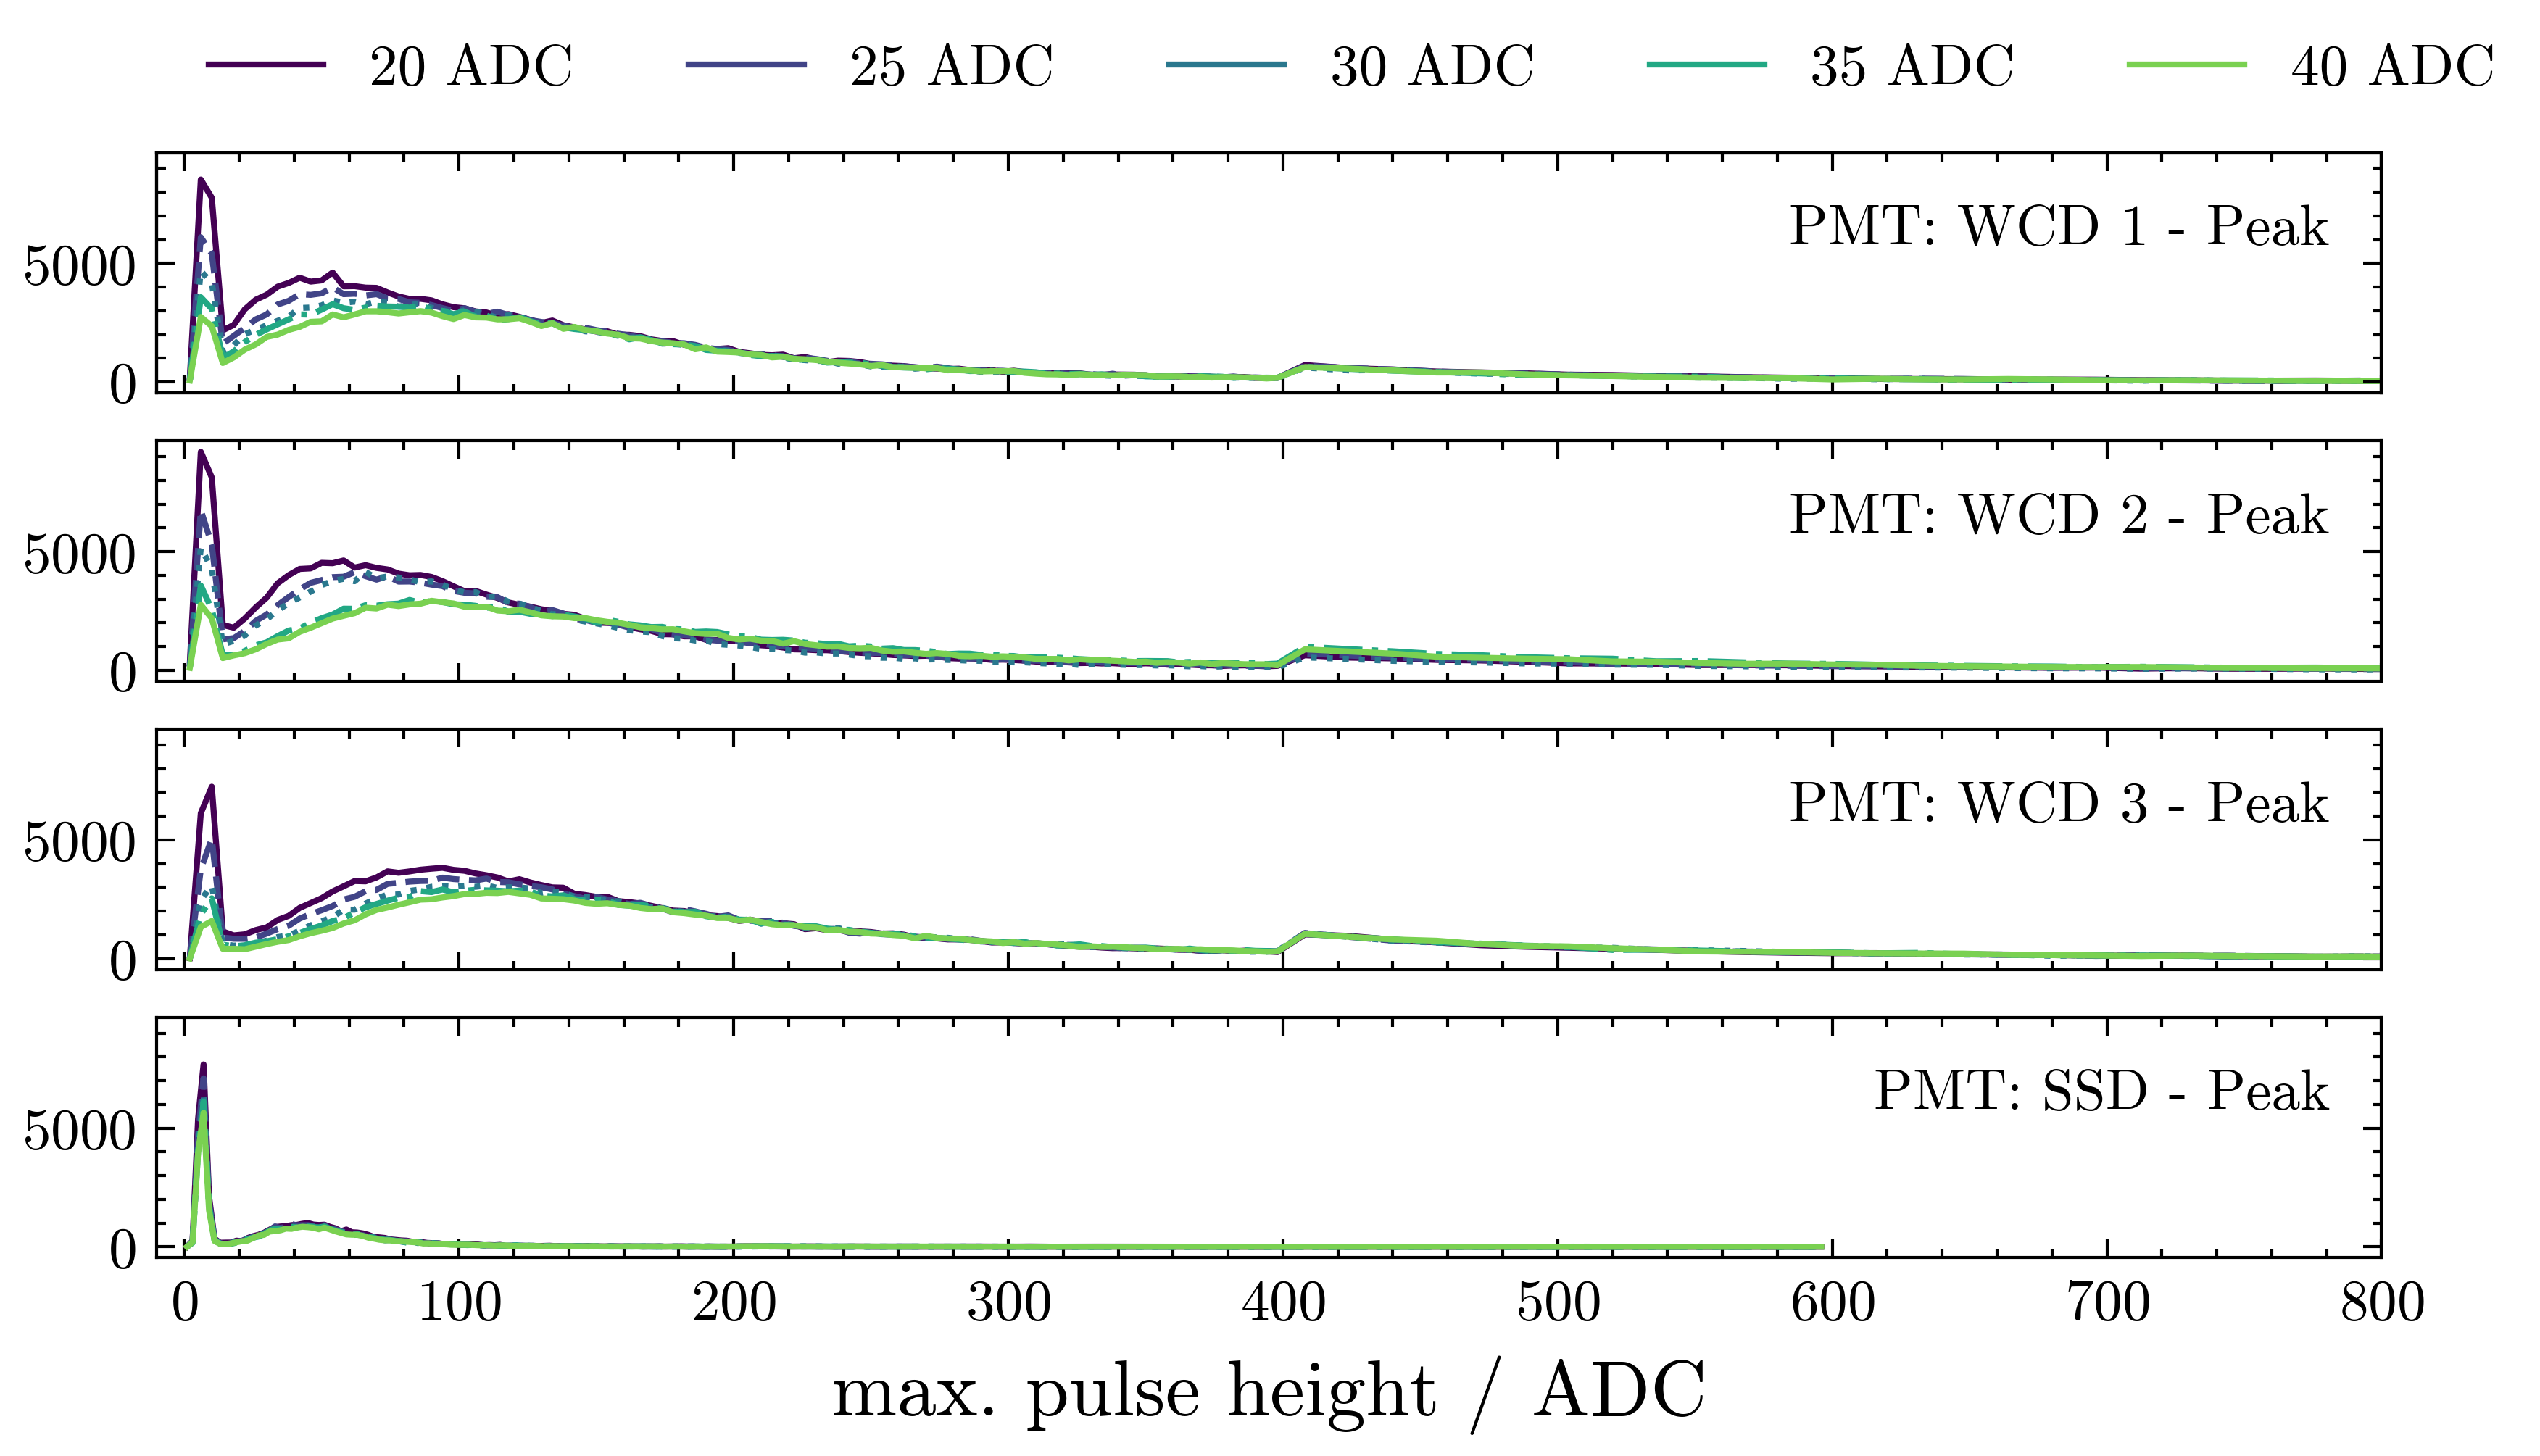

In [99]:
from utils.plotting import *
from utils import CONSTANTS

data = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v32/peak.txt')
data = np.split(data, 5)

_, axes = plt.subplots(4, sharex=True, sharey=True)
colors = plot.gradient(plt.cm.viridis, 5)
fitted_charges = [[] for _ in range(4)]

for th, h, c in zip(thresholds, data, colors):
    for i, (pmt, ax) in enumerate(zip(h, axes)):
        _, _, t, p, *hist = pmt
        fitted_charges[i].append(make_histo_fit(np.array(hist), p, 'peak', t, 'v32'))
        bins = CONSTANTS.UUB_SSD_PEAK if i == 3 else CONSTANTS.UUB_WCD_PEAK
        ax.plot(bins, hist, c=c)

ax1_twin = axes[0].twinx()
ax1_twin.set_yticklabels([])
ax1_twin.set_ylim(*axes[0].get_ylim())

for th, c in zip(thresholds, colors):
    ax1_twin.plot([],[],c=c,ls='solid',label=f"{th} ADC")
ax1_twin.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=5)

titles = ['WCD 1', 'WCD 2', 'WCD 3', 'SSD']
for title, ax in zip(titles, axes):
    ax.legend(title=f'PMT: {title} - Peak')
    # ax.set_yscale('log')
    ax.set_xlim(-10, 800)
    # ax.set_ylim(40, 2000)
    
ax.set_xlabel('max. pulse height / ADC')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'integral / ADC')

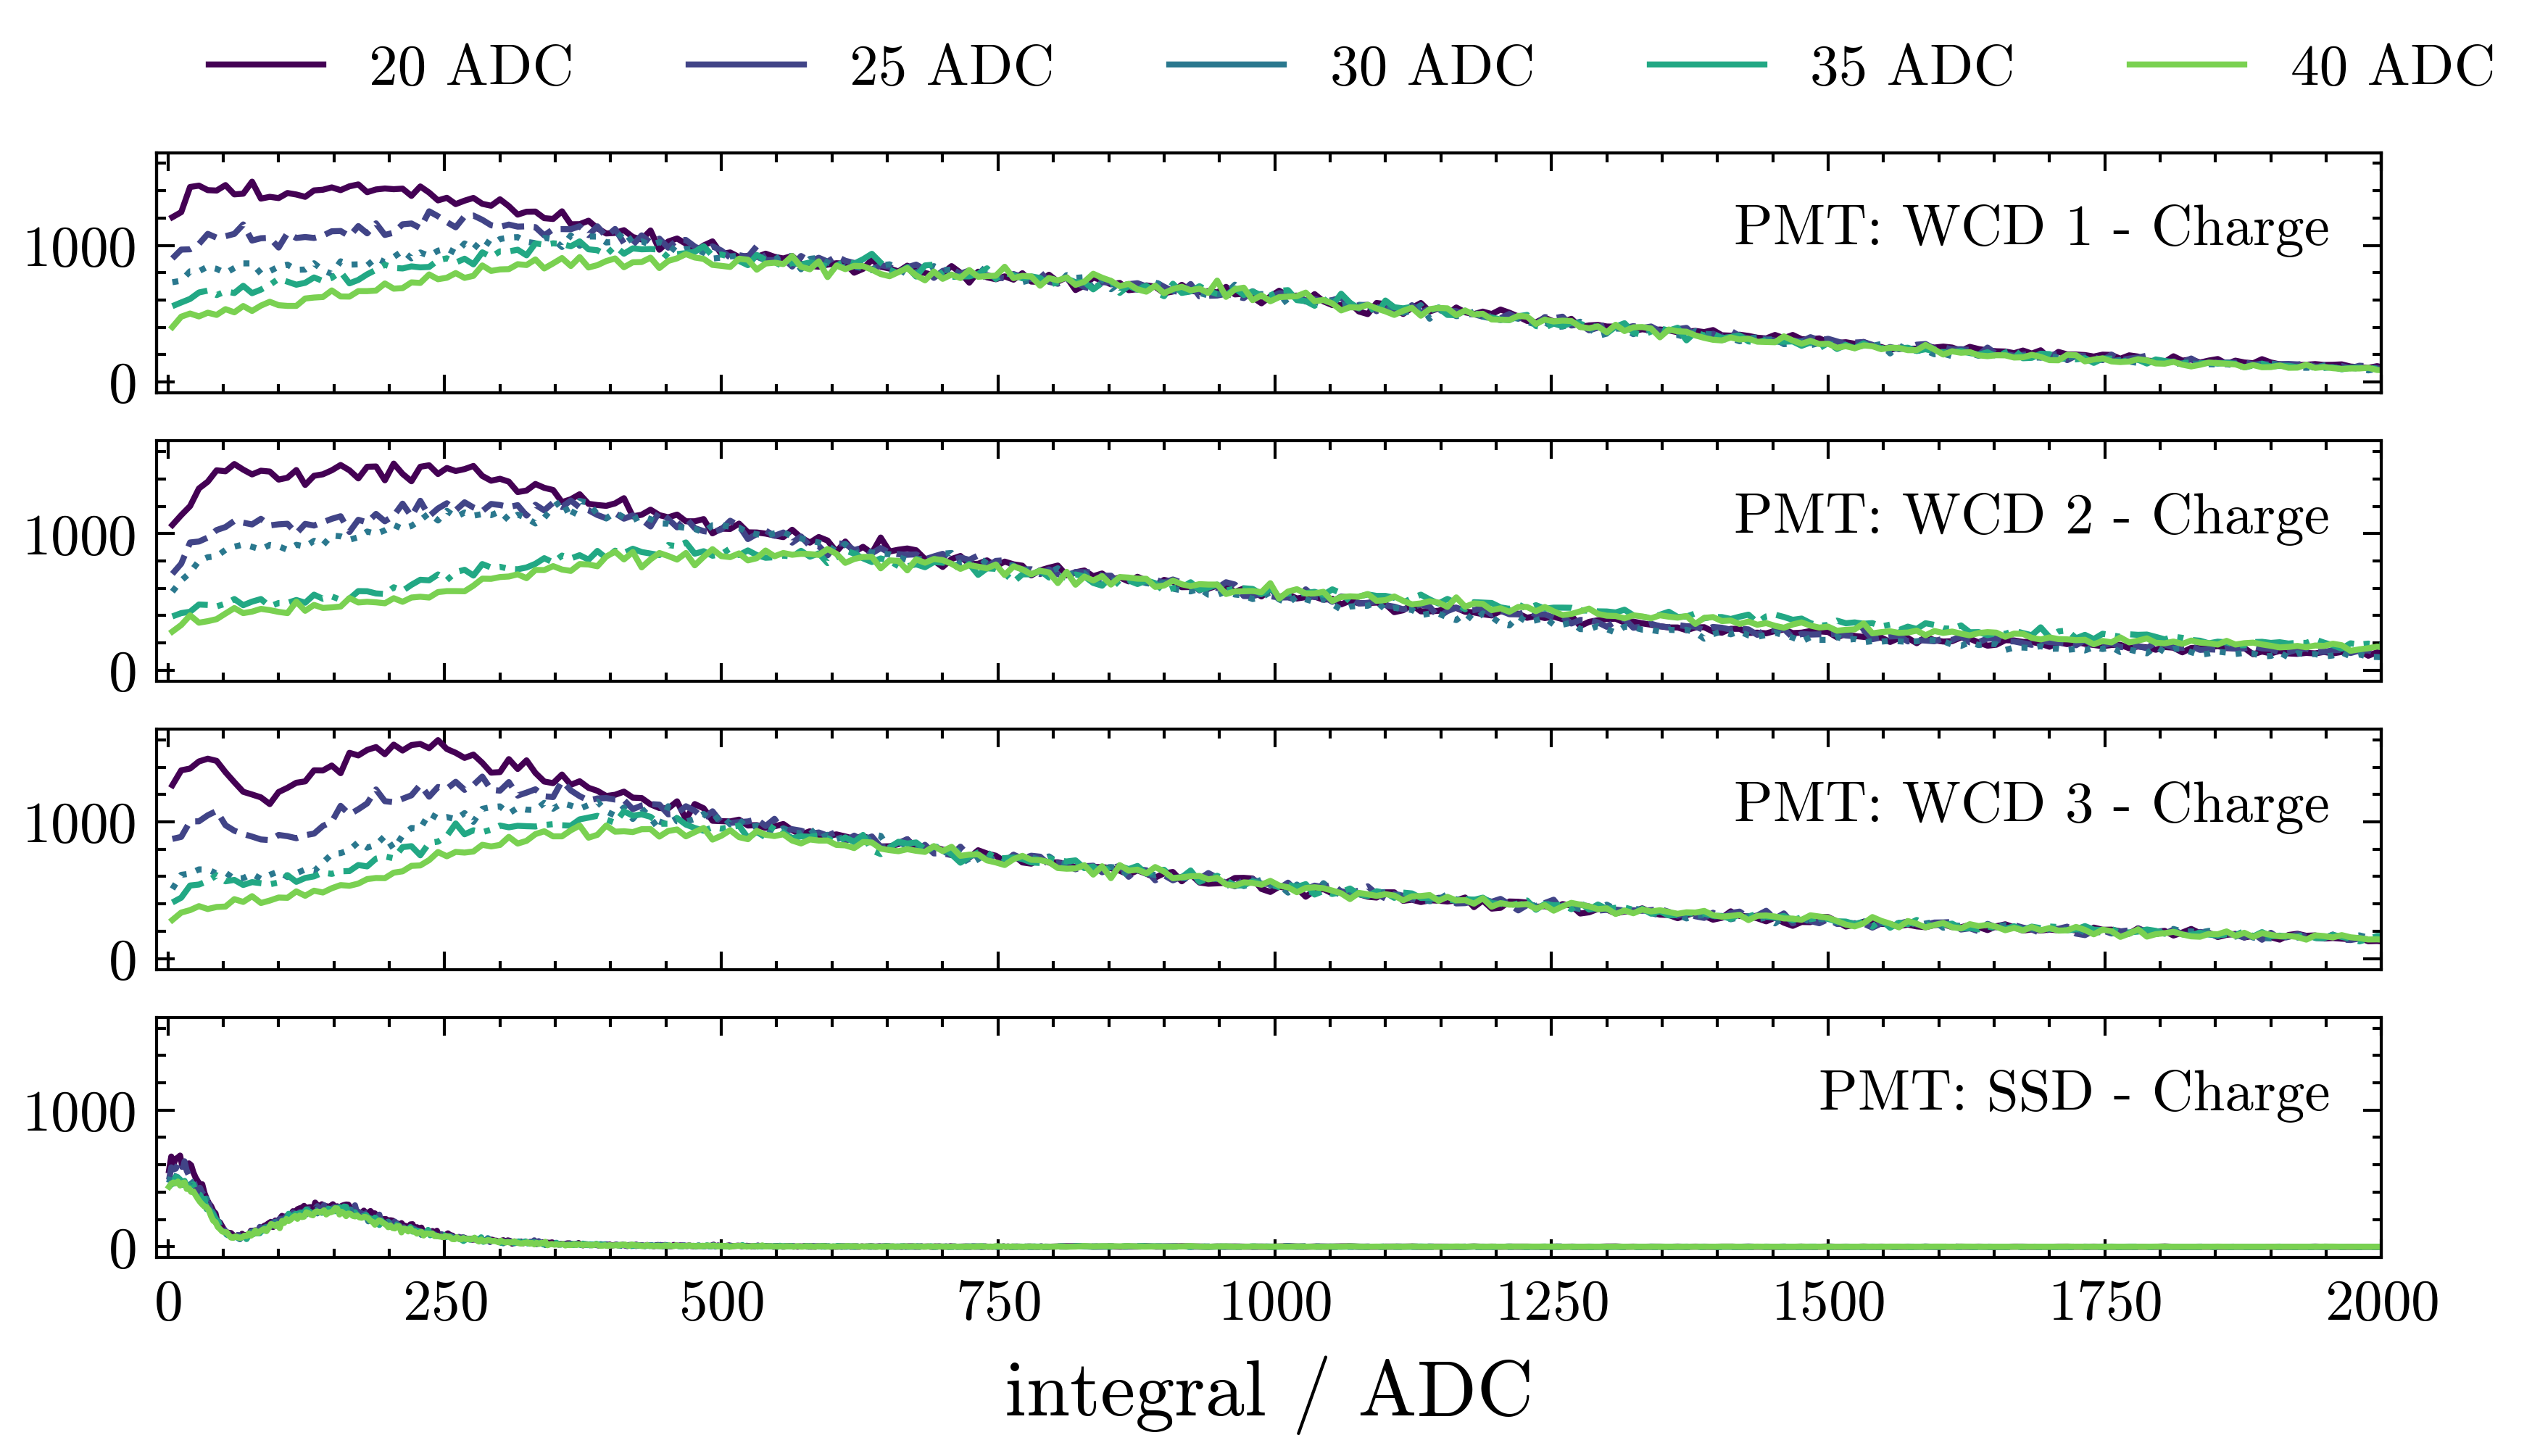

In [95]:
from utils.plotting import *
from utils import CONSTANTS

data = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v32/charge.txt')
data = np.split(data, 5)

_, axes = plt.subplots(4, sharex=True, sharey=True)
colors = plot.gradient(plt.cm.viridis, 5)
fitted_charges = [[] for _ in range(4)]

for th, h, c in zip(thresholds, data, colors):
    for i, (pmt, ax) in enumerate(zip(h, axes)):
        _, _, t, p, *hist = pmt
        fitted_charges[i].append(make_histo_fit(np.array(hist), p, 'charge', t, 'v32'))
        bins = CONSTANTS.UUB_SSD_CHARGE if i == 3 else CONSTANTS.UUB_WCD_CHARGE
        ax.plot(bins, hist, c=c)

ax1_twin = axes[0].twinx()
ax1_twin.set_yticklabels([])
ax1_twin.set_ylim(*axes[0].get_ylim())

for th, c in zip(thresholds, colors):
    ax1_twin.plot([],[],c=c,ls='solid',label=f"{th} ADC")
ax1_twin.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=5)

titles = ['WCD 1', 'WCD 2', 'WCD 3', 'SSD']
for title, ax in zip(titles, axes):
    ax.legend(title=f'PMT: {title} - Charge')
    # ax.set_yscale('log')
    ax.set_xlim(-10, 2000)
    # ax.set_ylim(40, 2000)
    
ax.set_xlabel('integral / ADC')

Text(0, 0.5, 'Offline peak')

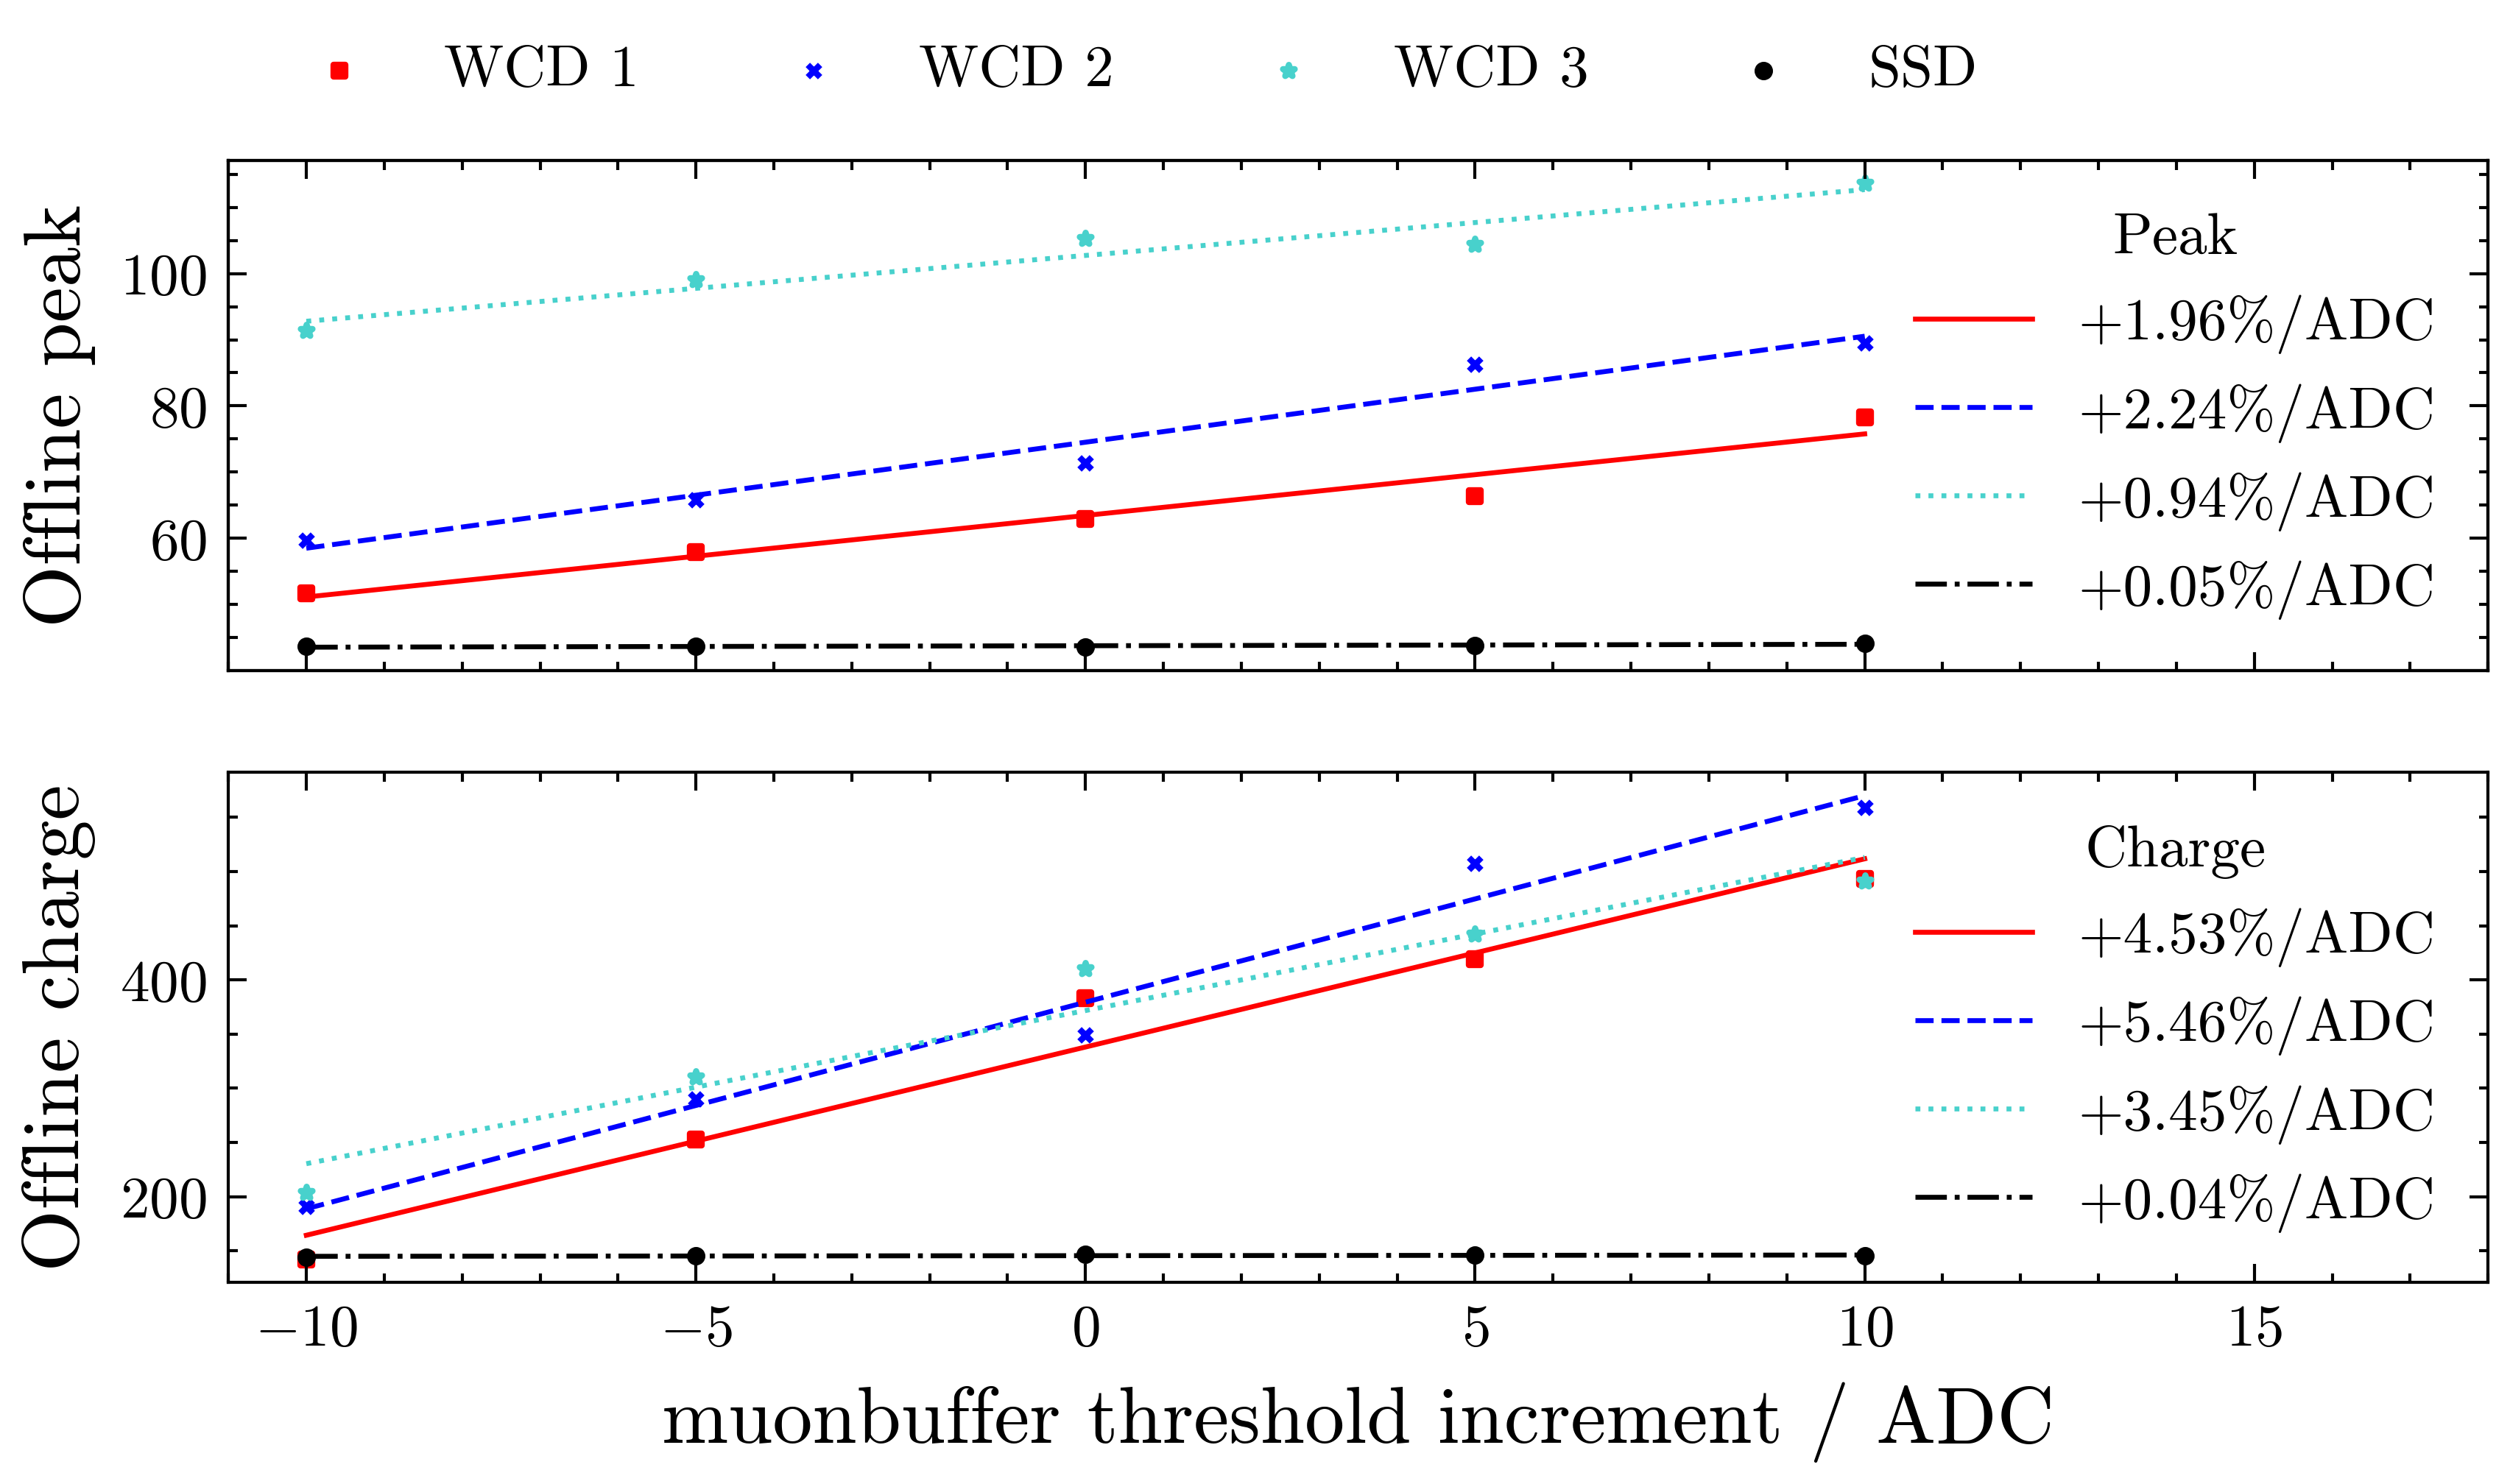

In [88]:
_, (ax1, ax2) = plt.subplots(2, sharex=True)
thresholds = np.array(thresholds)
color = ['r', 'b', 'mediumturquoise', 'k']
marker = ['s', 'x', '*', 'o']
lines, points, perc_peak = [], [], []
for charges, peaks, c, m in zip(fitted_charges, fitted_peaks, color, marker):
    if not len(charges): continue

    popt_peak = np.polyfit(thresholds-30, peaks, 1)
    perc_increase = popt_peak[0]/peaks[2] * 100
    l, = ax1.plot(thresholds-30, np.poly1d(popt_peak)(thresholds-30), c=c, lw=0.8, label=f'{perc_increase:+.2f}%/ADC')
    p = ax1.scatter(thresholds - 30, peaks, c=c, marker=m)

    lines.append(l), points.append(p)

    popt_charge = np.polyfit(thresholds-30, charges, 1)
    perc_increase = popt_charge[0]/charges[2] * 100
    ax2.plot(thresholds-30, np.poly1d(popt_charge)(thresholds-30), c=c, lw=0.8, label=f'{perc_increase:+.2f}%/ADC')
    ax2.scatter(thresholds - 30, charges, c=c, marker=m)


titles = ['WCD 1', 'WCD 2', 'WCD 3', 'SSD']
ax1_twin = ax1.twinx()
for c, t, m in zip(color, titles, marker):
    ax1_twin.scatter([],[],c=c, marker=m, label=t)
ax1_twin.set_yticklabels([])
ax1_twin.set_ylim(*ax1.get_ylim())
ax1_twin.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
# ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
# legend1 = plt.legend(points, perc_peak, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", ncol=4)

ax1.legend(title='Peak')

ax1.set_xlim(-11, 18)
ax1.set_xlim(-11, 18)
# ax1.legend(title='Peak')
ax2.legend(title='Charge')
ax2.set_xlabel('muonbuffer threshold increment / ADC')
ax2.set_ylabel('Offline charge')
ax1.set_ylabel('Offline peak')

11:47:29 (   +4.6s) [INFO   ] -- received 1 file(s) as input
11:47:30 (  +178ms) [INFO   ] -- View monit keys with self.keys()
11:47:30 (    +5ms) [INFO   ] -- found 35 entries for key fPeak and station #136
11:47:30 (    +6ms) [INFO   ] -- found 35 entries for key fTime and station #136


Text(0, 0.5, 'online peak / ADC')

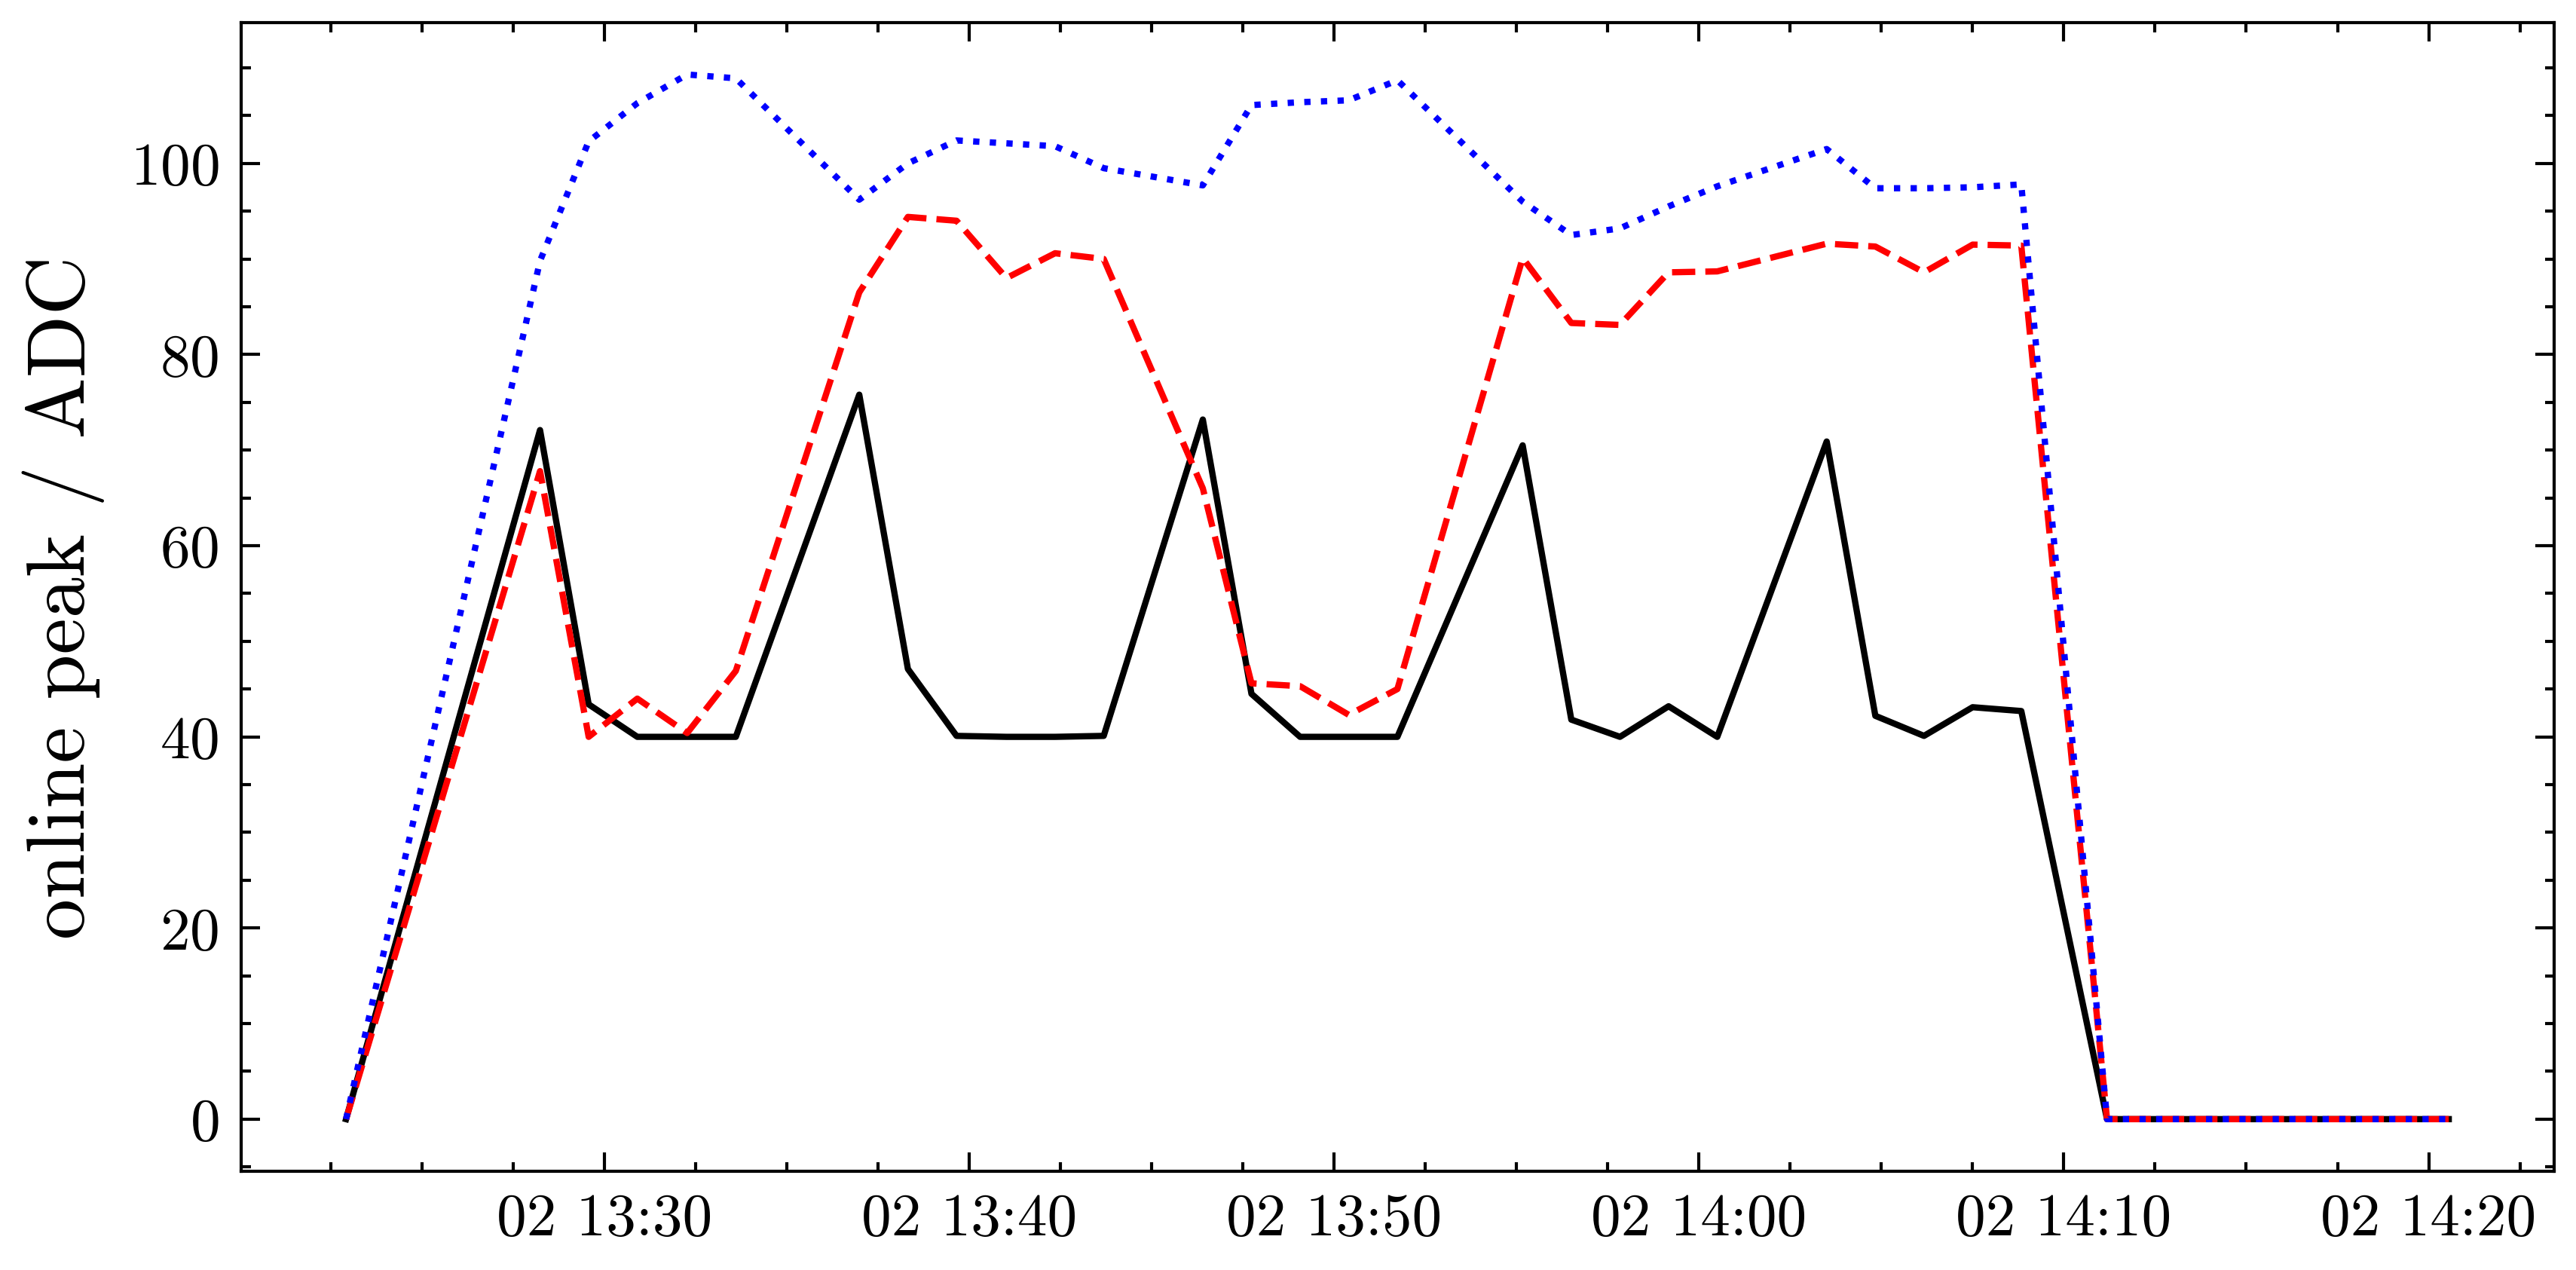

In [107]:
from utils.Auger.SD.Monitoring import Monit

monit = Monit('/cr/data01/filip/Data/daqIntegrationTests/v32/mc_2024_10_02_13h24.root')

vem = monit('fPeak', 136)
time = monit('fTime', 136)

plt.plot(plot.to_datetime(time), vem)
plt.ylabel('online peak / ADC')